In [1]:
from pydub import AudioSegment
from pydub.generators import Sine
import numpy as np
import matplotlib.pyplot as plt 
import pygame
from musicpy import *
import math as m
import time
from midi2audio import FluidSynth
import os
import shutil
import mpmath

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


Podemos poner la escala cromatica que consta de 12 tonos en dos equivalencias notacionales distintas, en las que en ambos casos $\#$ indica subir un semitono y $\flat$ bajar un semitono:

$$\text{Do } = \text{C}$$
$$\text{Do}\# = \text{C}\#=\text{Re}\flat=\text{D}\flat$$
$$\text{Re }=\text{D}$$
$$\text{Re}\# =\text{D}\#= \text{Mi}\flat =\text{E}\flat$$
$$\text{Mi } =\text{E}$$
$$\text{Fa }=\text{F}$$
$$\text{Fa}\# =\text{F}\# = \text{Sol}\flat =\text{G}\flat$$
$$\text{Sol }=\text{G}$$
$$\text{Sol}\# =\text{G}\# = \text{La}\flat=\text{A}\flat$$
$$\text{La } =\text{A}$$
$$\text{La}\#=\text{A}\# = \text{Si}\flat \text{B}\flat$$
$$\text{Si } =\text{B}$$

Dado que la escala cromatica se repite una y otra vez en direccion de los agudos y los grabes tenemos que podemos asignar cada tono de la siguiente forma: 

Sea $t$ un tono $t\in G_{12}$ donde $G_{12}$ es el grupo de residuos modulo 12, así cada tono esta representado por una clase de equivalencia

$$\text{Do } \in [0]$$
$$\text{Do}\# = \text{Re}\flat \in [1]$$
$$\text{Re } \in [2]$$
$$\text{Re}\# = \text{Mi}\flat \in [3]$$
$$\text{Mi } \in [4]$$
$$\text{Fa } \in [5]$$
$$\text{Fa}\# = \text{Sol}\flat \in [6]$$
$$\text{Sol } \in [7]$$
$$\text{Sol}\# = \text{La}\flat \in [8]$$
$$\text{La } \in [9]$$
$$\text{La}\# = \text{Si}\flat \in [10]$$
$$\text{Si } \in [11]$$

Para calcular las frecuencias de las notas en la escala cromática, podemos usar la fórmula general para calcular la frecuencia de una nota en una escala temperada. La fórmula es:

$$f=f_0​\times 2^{n/12}$$

donde:

$f$ es la frecuencia de la nota.

$f_0$​ es la frecuencia de referencia de la nota de afinación estándar (por ejemplo, A4 = 440 Hz).

$n$ es el número de semitonos que la nota está por encima (o por debajo) de la nota de referencia.


Tomando A4 (440 Hz) como referencia, podemos calcular :

\begin{align*}
    \text{C1:} & \quad f = 440 \times 2^{-\frac{9}{12}} \approx 261.63 \, \text{Hz} \\
    \text{C\#1:} & \quad f = 440 \times 2^{-\frac{8}{12}} \approx 277.18 \, \text{Hz} \\
    \text{D2:} & \quad f = 440 \times 2^{-\frac{7}{12}} \approx 293.66 \, \text{Hz} \\
    \text{D\#2:} & \quad f = 440 \times 2^{-\frac{6}{12}} \approx 311.13 \, \text{Hz} \\
    \text{E3:} & \quad f = 440 \times 2^{-\frac{5}{12}} \approx 329.63 \, \text{Hz} \\
    \text{F4:} & \quad f = 440 \times 2^{-\frac{4}{12}} \approx 349.23 \, \text{Hz} \\
    \text{F\#4:} & \quad f = 440 \times 2^{-\frac{3}{12}} \approx 369.99 \, \text{Hz} \\
    \text{G5:} & \quad f = 440 \times 2^{-\frac{2}{12}} \approx 392.00 \, \text{Hz} \\
    \text{G\#5:} & \quad f = 440 \times 2^{-\frac{1}{12}} \approx 415.30 \, \text{Hz} \\
    \text{A6:} & \quad f = 440 \times 2^{0} = 440.00 \, \text{Hz} \\
    \text{A\#6:} & \quad f = 440 \times 2^{\frac{1}{12}} \approx 466.16 \, \text{Hz} \\
    \text{B7:} & \quad f = 440 \times 2^{\frac{2}{12}} \approx 493.88 \, \text{Hz} \\
\end{align*}

Para armonizar un poco podemos ocupar cada nota en una representación de acorde 

    C1: Cmaj
    C#1: C#maj
    D2: Dmaj
    D#2: D#maj
    E3: Emaj
    F4: Fmaj
    F#4: F#maj
    G5: Gmaj
    G#5: G#maj
    A6: Amaj
    A#6: A#maj
    B7: Bmaj
  

Usemos los Primeros  dígitos de $\pi$ para hacerlos sonar como una melodia, esto es sencillo puees los digitos $d$ de $\pi$ deben cumplir con $d\in [0,1,2,3,4,5,6,7,8,9]$ por lo que podemos hacer a asignación trivial  
$$0\to [0]$$
$$1\to [1]$$
$$2\to [2]$$
$$3\to [3]$$
$$4\to [4]$$
$$5\to [5]$$
$$6\to [6]$$
$$7\to [7]$$
$$8\to [8]$$
$$9\to [9]$$

In [2]:
def reproducir_wav(ruta):
    pygame.init()
    pygame.mixer.init()

    try:
        pygame.mixer.music.load(ruta)
        pygame.mixer.music.play()

        while pygame.mixer.music.get_busy():
            pygame.time.delay(100)
    except Exception as e:
        print(f"Error al reproducir el archivo: {e}")
    finally:
        pygame.mixer.quit()
        pygame.quit()

In [29]:
def Grafica(cadena,name):
    if isinstance(cadena, str):
        digits_list = [int(digit) for digit in cadena if digit.isdigit()]
    else:
        digits_list=cadena    
    percentage_counts = [digits_list.count(digit) / len(digits_list) * 100 for digit in range(10)]
    # Crea una secuencia de números para el eje x
    x_values = range(1, len(digits_list) + 1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6)) 

    #sactter plot
    ax1.scatter(x_values,digits_list, marker='o', color='black',s=3)
    ax1.set_title('Dígitos de '+name)
    ax1.set_xlabel('Posición')
    ax1.set_ylabel('Dígito')
    ax1.set_yticks(range(10))

    #histograna
    ax2.bar(range(10), percentage_counts, color='blue')
    ax2.set_xticks(range(10))
    ax2.set_title('Dígitos de '+name)
    ax2.set_xlabel('Dígito')
    ax2.set_ylabel('Porcentaje')

    #pie
    ax3.pie(percentage_counts, labels=range(10), autopct='%1.1f%%', colors=['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan'])
    ax3.set_title('Dígitos de '+name)

    #plt.tight_layout()
    plt.show()

In [4]:
# Mapeo de dígitos a notas de piano
digit_piano_notes = {
    "0": "C1",
    "1": "C#1",
    "2": "D2",
    "3": "D#2",
    "4": "E3",
    "5": "F4",
    "6": "F#4",
    "7": "G5",
    "8": "G#5",
    "9": "A6",
    "10": "A#6",
    "11": "B7",
    ".": "",  # Pausa para el punto decimal
}

# Mapeo de notas de piano a frecuencias (puedes ajustar estos valores según tus preferencias)
piano_note_freqs = {
    "C1":261.63,
    "C#1":277.18,
    "D2":293.66,
    "D#2":311.13,
    "E3":329.63,
    "F4":349.23,
    "F#4":369.99,
    "G5":392.00,
    "G#5":415.30,
    "A6":440.00,
    "A#6":466.16,
    "B7":493.88,
}

In [5]:
# Función para generar un tono basado en un dígito
def genera_cancion_basica(digits,name):
    # Duración predeterminada en milisegundos
    default_duration = 200
    melodia = AudioSegment.silent(duration=0)
    for digito in digits:
        #generar  tono para piano
        if digito in digit_piano_notes:
            nota = digit_piano_notes[digito]
            if nota == "":  # Pausa para el punto decimal
                tono=AudioSegment.silent(duration=default_duration)
            #generar nota basada en el tono para piano
            if nota in piano_note_freqs:
                frecuencia = piano_note_freqs[nota]
                tono= Sine(frecuencia).to_audio_segment(duration=default_duration)
            else:
                tono=AudioSegment.silent(duration=default_duration)
        else:
            tono=AudioSegment.silent(duration=default_duration)
        melodia += tono
    melodia.export("/home/deadwolf/MMT/"+name+"/melodia_basica_"+name+".wav", format="wav")
    print("Melodía generada y guardada como melodia_basica_"+name+".wav")

In [6]:
acordes = {
    "0": "Cmaj",
    "1": "C#maj",
    "2": "Dmaj",
    "3": "D#maj",
    "4": "Emaj",
    "5": "Fmaj",
    "6": "F#maj",
    "7": "Gmaj",
    "8": "G#maj",
    "9": "Amaj",
    "10": "A#maj",
    "11": "Bmaj",
}

instrumentos={
    "piano": 1,
    "g_acustica": 25,
    "g_electrica": 30,
    "g_armonicos":32,
    "bajo": 34,    
}

In [7]:
def convierte_wav(paths,n):
    # Convertir archivos MIDI a audio
    fs = FluidSynth()
    for index, path in enumerate(paths):
        name=path.split('_')[-1].replace('.mid','')
        fs.midi_to_audio(path,n+'_'+name+'.wav')


def compone_wav(path1,path2,n):
    name1=path1.split('_')[-1]
    name2=path2.split('_')[-1]
    # Cargar archivos de audio
    audio = AudioSegment.from_wav(n+'_'+name1)
    audio2=AudioSegment.from_wav(n+'_'+name2)
    # Superponer las pistas
    melodia_compuesta = audio.overlay(audio2)

    # Guardar la melodía compuesta
    melodia_compuesta.export(n+"_"+name1.replace('.wav','')+"+"+name2.replace('.wav','')+'.wav', format='wav')

In [31]:
def genera_melodia_armonica(digits,mode):
    music=[]
    for digit in digits:
        if isinstance(digit, str):
            pass
        else:
            digit=str(digit)
        if digit != '.':
            if mode == 'M':
                acorde=(C(acordes[digit],3,phi, 1/8))
            else:
                acorde=(C(acordes[digit],3,1/4, 1/8))
            music.append(acorde)

    return music

In [9]:
def projec_pipeline(digits,name,bpm):
    Grafica(digits,name)
    os.makedirs("/home/deadwolf/MMT/"+name)
    genera_cancion_basica(digits,name)
    music=genera_melodia_armonica(digits,'o')
    play(music, bpm=bpm, instrument=instrumentos['g_acustica'])
    os.rename("/home/deadwolf/MMT/temp.mid", "/home/deadwolf/MMT/"+str(bpm)+"_"+name+"_acustica.mid")
    shutil.move("/home/deadwolf/MMT/"+str(bpm)+"_"+name+"_acustica.mid", "/home/deadwolf/MMT/"+name)
    play(music, bpm=bpm, instrument=instrumentos['g_armonicos'])
    os.rename("/home/deadwolf/MMT/temp.mid", "/home/deadwolf/MMT/"+str(bpm)+"_"+name+"_armonica.mid")
    shutil.move("/home/deadwolf/MMT/"+str(bpm)+"_"+name+"_armonica.mid", "/home/deadwolf/MMT/"+name)
    play(music, bpm=bpm, instrument=instrumentos['g_electrica'])
    os.rename("/home/deadwolf/MMT/temp.mid", "/home/deadwolf/MMT/"+str(bpm)+"_"+name+"_electrica.mid")
    shutil.move("/home/deadwolf/MMT/"+str(bpm)+"_"+name+"_electrica.mid", "/home/deadwolf/MMT/"+name)
    
    paths=["/home/deadwolf/MMT/"+name+"/"+str(bpm)+"_"+name+"_acustica.mid","/home/deadwolf/MMT/"+name+"/"+str(bpm)+"_"+name+"_electrica.mid","/home/deadwolf/MMT/"+name+"/"+str(bpm)+"_"+name+"_armonica.mid"]
    convierte_wav(paths,name)
    compone_wav("/home/deadwolf/MMT/"+name+"_electrica.wav","/home/deadwolf/MMT/"+name+"_armonica.wav",name)
    compone_wav("/home/deadwolf/MMT/"+name+"_electrica+armonica.wav","/home/deadwolf/MMT/"+name+"_acustica.wav",name)
    shutil.move("/home/deadwolf/MMT/"+name+"_electrica.wav", "/home/deadwolf/MMT/"+name)
    shutil.move("/home/deadwolf/MMT/"+name+"_armonica.wav", "/home/deadwolf/MMT/"+name)
    shutil.move("/home/deadwolf/MMT/"+name+"_acustica.wav", "/home/deadwolf/MMT/"+name)
    shutil.move("/home/deadwolf/MMT/"+name+"_electrica+armonica.wav", "/home/deadwolf/MMT/"+name)
    shutil.move("/home/deadwolf/MMT/"+name+"_electrica+armonica+acustica.wav", "/home/deadwolf/MMT/"+name)

In [10]:
def numeros_modulo12(lista):
    # Aplicar módulo 12 a cada elemento de la lista 
    resultado = [num%12 for num in lista]
    return resultado

Un acode sonara mucho mas melodico por ejemplo 

In [11]:
#El equivalente a Do suena mas melodico usando guitarra acustica
acorde = (C('Cmaj', 3, 1/4, 1/8)) 
play(acorde, bpm=150, instrument=32)

Pero si usamos otro enigmatico,el número aureo $$\phi=\frac{1+\sqrt{5}}{2}$$  como fracción del tiempo para el acorde obtenemos una melodia más armonica

In [12]:
phi=(1+m.sqrt(5))/2

In [13]:
#El equivalente a Do suena mas armonico usando guitarra acustica y phi
acorde = (C('Cmaj', 3,phi, 1/8)) 
play(acorde, bpm=150, instrument=32)

<h1>Hagamos sonar números interesantes</h1>

Hagamos uso de los primeros 1400 digitos de $\displaystyle \pi=\sqrt{12}\sum_{n=0}^\infty \frac{(-3)^{-n}}{2n+1}$ para gener una melodia

In [14]:
#tomemos los 2000 primeros digitos de pi
mpmath.mp.dps = 2000
pi_digits = str(mpmath.mp.pi)

In [15]:
print(pi_digits)    
print("Tenemos "+str(len(pi_digits)-1)+" digitos de pi")

3.14159265358979323846264338327950288419716939937510582097494459230781640628620899862803482534211706798214808651328230664709384460955058223172535940812848111745028410270193852110555964462294895493038196442881097566593344612847564823378678316527120190914564856692346034861045432664821339360726024914127372458700660631558817488152092096282925409171536436789259036001133053054882046652138414695194151160943305727036575959195309218611738193261179310511854807446237996274956735188575272489122793818301194912983367336244065664308602139494639522473719070217986094370277053921717629317675238467481846766940513200056812714526356082778577134275778960917363717872146844090122495343014654958537105079227968925892354201995611212902196086403441815981362977477130996051870721134999999837297804995105973173281609631859502445945534690830264252230825334468503526193118817101000313783875288658753320838142061717766914730359825349042875546873115956286388235378759375195778185778053217122680661300192787661119590921642019

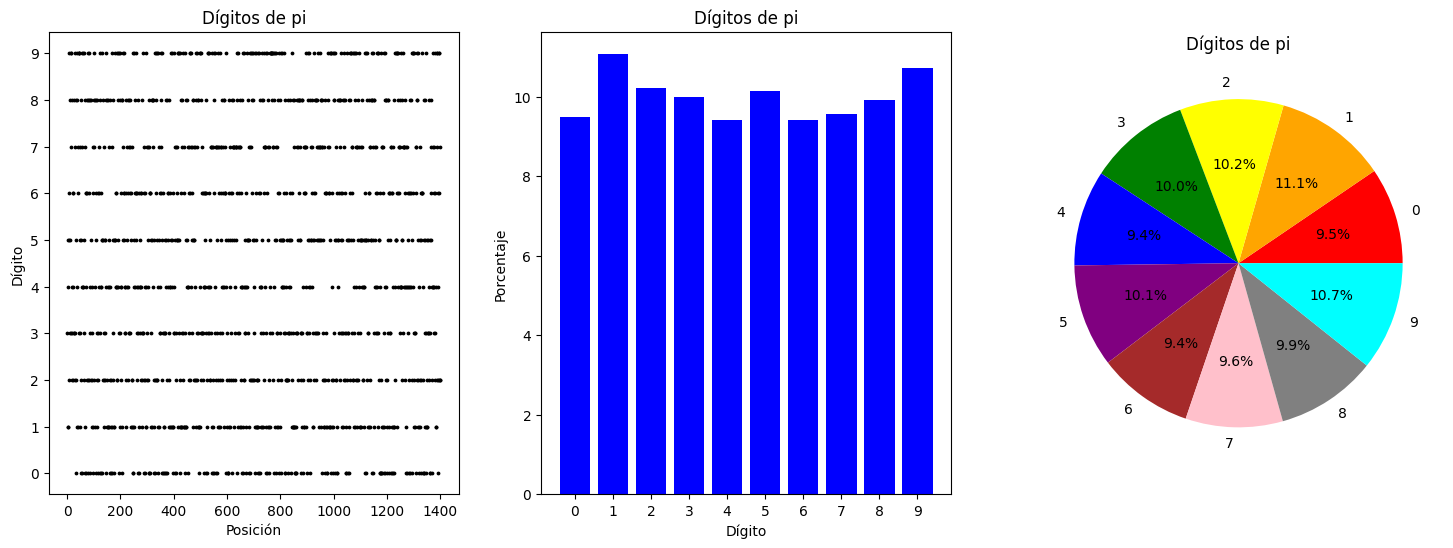

Melodía generada y guardada como melodia_basica_pi.wav


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'pi_acustica.wav'..


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'pi_electrica.wav'..


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'pi_armonica.wav'..


In [16]:
projec_pipeline(pi_digits[0:1401],'pi',150)

Hagamos uso de los primeros 1400 diguitos de $\displaystyle e=\sum_{n=0}^\infty \frac{1}{n!}$ para gener una melodia

In [17]:
# Calcula el número euler (e) con la precisión especificada
e_digits = str(mpmath.mp.e)

In [18]:
print(e_digits)
print("Tenemos "+str(len(e_digits)-1)+" digitos de e")

2.71828182845904523536028747135266249775724709369995957496696762772407663035354759457138217852516642742746639193200305992181741359662904357290033429526059563073813232862794349076323382988075319525101901157383418793070215408914993488416750924476146066808226480016847741185374234544243710753907774499206955170276183860626133138458300075204493382656029760673711320070932870912744374704723069697720931014169283681902551510865746377211125238978442505695369677078544996996794686445490598793163688923009879312773617821542499922957635148220826989519366803318252886939849646510582093923982948879332036250944311730123819706841614039701983767932068328237646480429531180232878250981945581530175671736133206981125099618188159304169035159888851934580727386673858942287922849989208680582574927961048419844436346324496848756023362482704197862320900216099023530436994184914631409343173814364054625315209618369088870701676839642437814059271456354906130310720851038375051011574770417189861068739696552126715468895703503

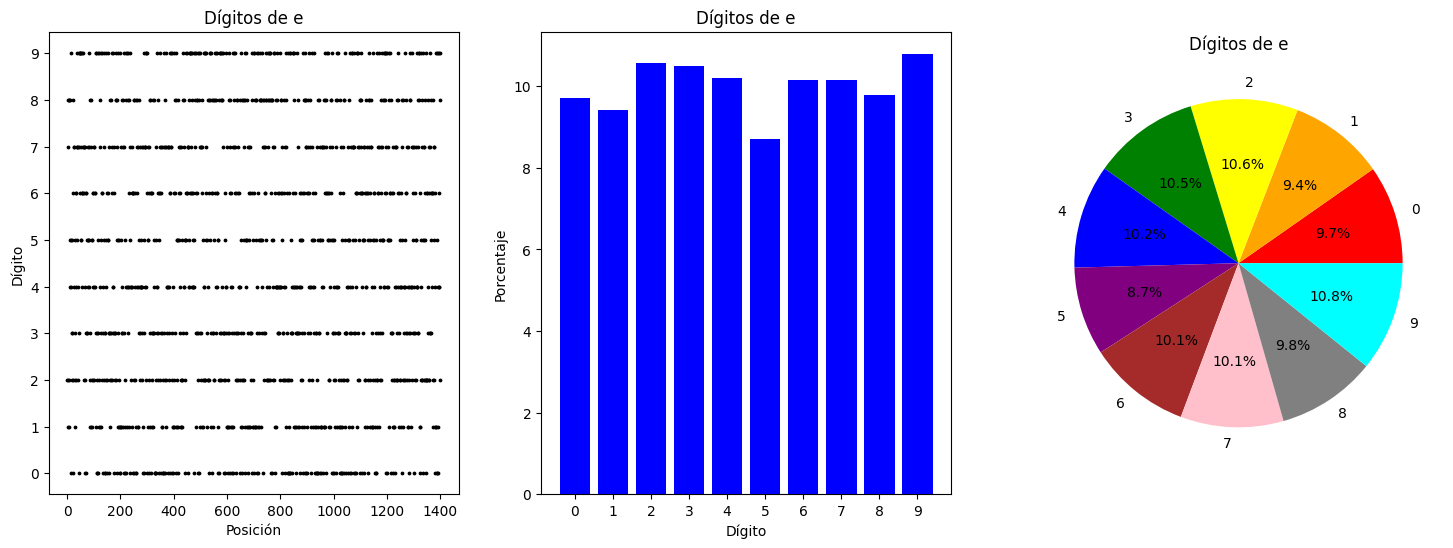

Melodía generada y guardada como melodia_basica_e.wav


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'e_acustica.wav'..


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'e_electrica.wav'..


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'e_armonica.wav'..


In [19]:
projec_pipeline(e_digits[0:1401],'e',150)

Hagamos uso de los primeros 1400 digitos de $\displaystyle \phi=\frac{1+\sqrt{5}}{2}$ para gener una melodia

In [20]:
phi_digits = str(mpmath.phi)

In [21]:
print(phi_digits)
print("Tenemos "+str(len(phi_digits)-1)+" digitos de phi")

1.61803398874989484820458683436563811772030917980576286213544862270526046281890244970720720418939113748475408807538689175212663386222353693179318006076672635443338908659593958290563832266131992829026788067520876689250171169620703222104321626954862629631361443814975870122034080588795445474924618569536486444924104432077134494704956584678850987433944221254487706647809158846074998871240076521705751797883416625624940758906970400028121042762177111777805315317141011704666599146697987317613560067087480710131795236894275219484353056783002287856997829778347845878228911097625003026961561700250464338243776486102838312683303724292675263116533924731671112115881863851331620384005222165791286675294654906811317159934323597349498509040947621322298101726107059611645629909816290555208524790352406020172799747175342777592778625619432082750513121815628551222480939471234145170223735805772786160086883829523045926478780178899219902707769038953219681986151437803149974110692608867429622675756052317277752035361393

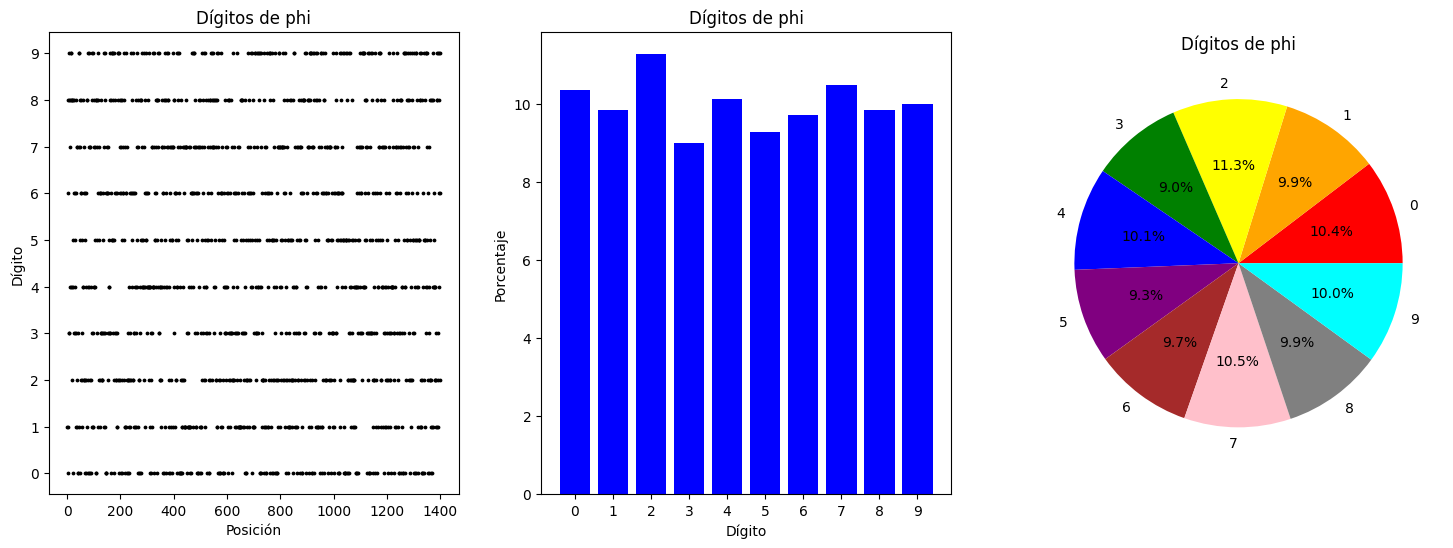

Melodía generada y guardada como melodia_basica_phi.wav


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'phi_acustica.wav'..


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'phi_electrica.wav'..


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'phi_armonica.wav'..


In [23]:
projec_pipeline(phi_digits[0:1401],'phi',150)

Hagamos uso de los primeros 2000 numeros primos en modulo 12 para generar una melodia

In [24]:
#generando los primero 2000 primos
def criba_eratostenes(n):
    # Inicializar una lista de booleanos para representar los números primos
    is_prime = [True] * (n + 1)
    
    # 0 y 1 no son primos
    is_prime[0] = is_prime[1] = False
    
    # Marcar los múltiplos como no primos
    for i in range(2, int(n**0.5) + 1):
        if is_prime[i]:
            for j in range(i * i, n + 1, i):
                is_prime[j] = False
    
    # Crear una lista con los números primos encontrados
    primes = [i for i in range(2, n + 1) if is_prime[i]]
    
    return primes
primos = criba_eratostenes(17390)    

In [25]:
print("Tenemos "+str(len(primos))+" números primos")

Tenemos 2000 números primos


In [26]:
primos12=numeros_modulo12(primos)

In [27]:
print("Tenemos "+str(len(primos12))+" números primos en modulo 12")

Tenemos 2000 números primos en modulo 12


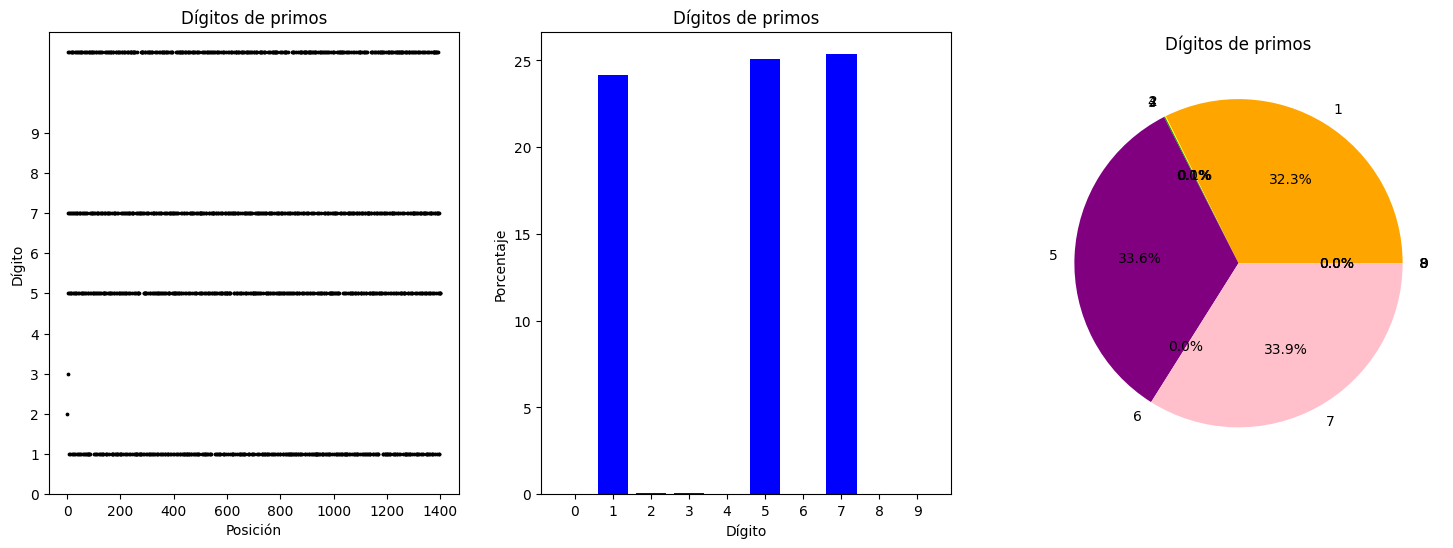

Melodía generada y guardada como melodia_basica_primos.wav


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'primos_acustica.wav'..


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'primos_electrica.wav'..


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'primos_armonica.wav'..


In [33]:
projec_pipeline(primos12[0:1400],'primos',150)

Hagamos uso de los primeros 2000 numeros de fibonacci en modulo 12 para generar una melodia

In [34]:
def fibonacci(n):
    fib_sequence = [0, 1]
    while len(fib_sequence) < n:
        fib_sequence.append(fib_sequence[-1] + fib_sequence[-2])
    return fib_sequence[:n]
numeros_fibonacci = fibonacci(2000)    

In [35]:
print("Tenemos "+str(len(numeros_fibonacci))+"números de finbonacci")

Tenemos 2000números de finbonacci


In [36]:
f12=numeros_modulo12(numeros_fibonacci)
print("Tenemos "+str(len(f12))+" números de finbonacci en modulo 12")

Tenemos 2000 números de finbonacci en modulo 12


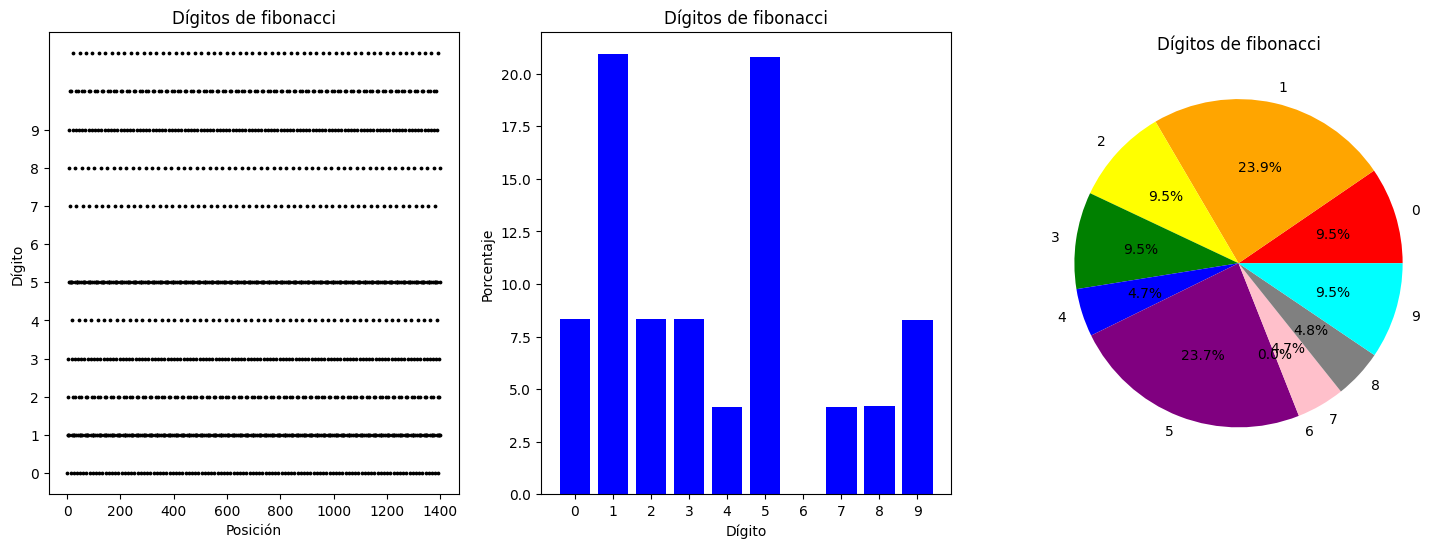

Melodía generada y guardada como melodia_basica_fibonacci.wav


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'fibonacci_acustica.wav'..


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'fibonacci_electrica.wav'..


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/deadwolf/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'fibonacci_armonica.wav'..


In [37]:
projec_pipeline(f12[0:1400],'fibonacci',150)